In [1]:
import cv2
import mediapipe as mp
import numpy as np
import cv2
import torch
from torch import nn
from models import LinkNet34
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
import time
import sys


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LinkNet34()
# model.load_state_dict(torch.load('linknet.pth'))
model.load_state_dict(torch.load('linknet.pth', map_location=lambda storage, loc: storage))
model.eval()
model.to(device)
1

/Users/leewonseok/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/leewonseok/anaconda3/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1

In [3]:
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

### 얼굴 감지 모델

In [4]:
face_detection = mp_face_detection.FaceDetection()

### OpenCV를 사용하여 비디오 스트림을 캡처

In [5]:
cap = cv2.VideoCapture(1)  # 웹캠 사용

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
2024-03-29 18:03:26.248 python[23742:1327242] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


### 얼굴 감지 및 segmentation(모델 사용 x)

In [6]:
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # 프레임을 RGB로 변환
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # 얼굴 감지 수행
    results = face_detection.process(frame_rgb)
    
    if results.detections:
        for detection in results.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
            roi = frame[y:y+h, x:x+w]  # ROI 추출

            roifilename = "roi_img.jpg"
            cv2.imwrite(roifilename, roi)
            
            # ROI를 HSV 색상 공간으로 변환
            roi_hsv = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

            # 피부 색상에 대한 범위 설정 (이 범위는 적절히 조정될 수 있습니다)
            lower_skin = np.array([0, 48, 80], dtype=np.uint8)
            upper_skin = np.array([20, 255, 255], dtype=np.uint8)

            # 피부 영역을 마스크로 만듭니다
            skin_mask = cv2.inRange(roi_hsv, lower_skin, upper_skin)

            # 피부 영역만 남기고 나머지는 검정색으로 처리
            skin_segmentation = cv2.bitwise_and(roi, roi, mask=skin_mask)

            # 세그멘테이션된 이미지를 원래 크기로 조정
            segmentation_resized = cv2.resize(skin_segmentation, (w, h))

            # 원본 프레임에 세그멘테이션된 영역을 추가합니다
            frame[y:y+h, x:x+w] = segmentation_resized
    
    # 화면에 출력
    cv2.imshow('Face Segmentation', frame)

    # 's' 키를 누르면 세그멘테이션된 ROI를 저장합니다.
    key = cv2.waitKey(1) & 0xFF
    if key == ord('s'):
        filename = "segmented_roi.jpg"
        cv2.imwrite(filename, segmentation_resized)
        print("Segmented ROI saved as", filename)
    
    # 'q' 키를 누르면 종료
    if key == ord('q'):
        break

# 종료
cap.release()
cv2.destroyAllWindows()


ValueError: could not broadcast input array from shape (512,512,3) into shape (512,478,3)

In [ ]:
img = cv2.imread('segmented_roi.jpg', cv2.IMREAD_COLOR)
cv2.imshow('img', img)

### Segmentation(deep learning 사용)

In [ ]:
import cv2
import numpy as np
import mediapipe as mp
import torch
from torchvision import transforms
from PIL import Image

# MediaPipe 얼굴 감지 초기화
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.5)

# 모델 로드 (사전에 학습된 LinkNet34 모델을 로드하는 코드를 추가하세요)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LinkNet34()
# model.load_state_dict(torch.load('linknet.pth'))
model.load_state_dict(torch.load('linknet.pth', map_location=lambda storage, loc: storage))
model.eval()
model.to(device)


face_counter = 0
# 비디오 캡처 초기화
cap = cv2.VideoCapture(1)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # 프레임을 RGB로 변환하여 얼굴 감지 수행
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detection.process(frame_rgb)
    
    if results.detections:
        for detection in results.detections:
            # 감지된 얼굴 영역 추출
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = frame.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
            roi = frame[y:y+h, x:x+w]

            roi_filename = f"roi_face_{face_counter}_{int(time.time())}.jpg"
            cv2.imwrite(roi_filename, roi)
            
            # 분할 모델을 위한 전처리
            transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
            roi_tensor = transform(roi).unsqueeze(0) # 모델 입력을 위한 텐서

            # 모델 적용 및 분할 마스크 생성ㅂㅂㅂ
            with torch.no_grad():
                mask_pred = model(roi_tensor)
                mask = mask_pred.squeeze().cpu().numpy()
                mask = (mask > 0.5).astype(np.uint8)  # 마스크를 uint8 타입으로 변환

            # 분할 결과 적용: 피부를 제외한 나머지 부분을 검은색으로 처리
            mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
            full_mask = np.zeros(frame.shape[:2], dtype=np.uint8)
            full_mask[y:y+h, x:x+w] = mask_resized
            frame[full_mask == 0] = [0, 0, 0]

            # 분할된 영역 이미지 파일로 저장
            segmented_face = np.zeros_like(roi)  # 분할된 얼굴 영역에 대한 빈 이미지 생성
            for c in range(3):  # 채널별로 마스크 적용
                segmented_face[:, :, c] = roi[:, :, c] * mask_resized
            
            

            # 분할된 얼굴 영역을 이미지 파일로 저장
            face_filename = f"segmented_face_{face_counter}_{int(time.time())}.jpg"
            cv2.imwrite(face_filename, segmented_face)
            print(f"Segmented face saved as {face_filename}")
            face_counter += 1

    cv2.imshow('Segmentation', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


Segmented face saved as segmented_face_0_1711608691.jpg
Segmented face saved as segmented_face_1_1711608691.jpg
Segmented face saved as segmented_face_2_1711608692.jpg
Segmented face saved as segmented_face_3_1711608692.jpg
Segmented face saved as segmented_face_4_1711608692.jpg
Segmented face saved as segmented_face_5_1711608693.jpg
Segmented face saved as segmented_face_6_1711608693.jpg
Segmented face saved as segmented_face_7_1711608693.jpg
Segmented face saved as segmented_face_8_1711608694.jpg
Segmented face saved as segmented_face_9_1711608694.jpg
Segmented face saved as segmented_face_10_1711608694.jpg
Segmented face saved as segmented_face_11_1711608694.jpg
Segmented face saved as segmented_face_12_1711608695.jpg
Segmented face saved as segmented_face_13_1711608695.jpg
Segmented face saved as segmented_face_14_1711608695.jpg
Segmented face saved as segmented_face_15_1711608696.jpg
Segmented face saved as segmented_face_16_1711608696.jpg
Segmented face saved as segmented_face_17

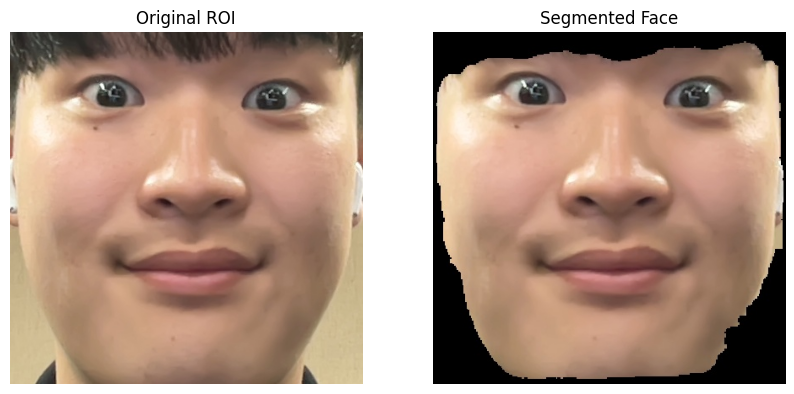

In [10]:
roi_img = cv2.imread('roi_face_46_1711608704.jpg', cv2.IMREAD_COLOR)
roi_img_rgb = cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB)

seg_img = cv2.imread('segmented_face_45_1711608704.jpg', cv2.IMREAD_COLOR)
seg_img_rgb = cv2.cvtColor(seg_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))  

plt.subplot(1, 2, 1)  
plt.imshow(roi_img_rgb)
plt.title('Original ROI')  
plt.axis('off')  

plt.subplot(1, 2, 2)  
plt.imshow(seg_img_rgb)
plt.title('Segmented Face')  
plt.axis('off')  

plt.show()